# Breakthrough curve for a geothermal doublet
## Analytical solution based on Schulz (1987)

This notebook implements the two-dimensional analytical model for heat transport in a confined aquifer with an injection–extraction well pair (a geothermal doublet) based on Schulz (1987). The model describes temperature changes in a saturated porous medium under steady groundwater flow, using Darcy’s law for flow and an advection–conduction heat transport equation in the aquifer and surrounding rock.

## Conceptual model

The aquifer is idealized as laterally extensive, with constant thickness, bounded above and below by impermeable formations, and with flow restricted to the horizontal plane. Material properties are assumed homogeneous and isotropic, vertical temperature variation within the aquifer is neglected, and vertical heat conduction into caprock and basement is treated in an effective way at the aquifer boundaries.

In the two-dimensional case, the flow field is constructed by superposing a dipole (injection and production wells) with an optional uniform regional flow. A conformal mapping to potential–streamfunction coordinates reduces the temperature problem to an integral along streamlines, which are solved numerically.

## Model outputs and use

Within this framework, the notebook computes isotherms, streamlines, and hydraulic potential, and evaluates production temperature as a function of operating time. Doublet performance is described by thermal breakthrough (first arrival of the injected thermal front at the production well) and the later gradual decline of production temperature due to mixing along multiple streamlines.

## Reference

Schulz, R. (1987). Analytical model calculations for heat exchange in a confined aquifer. Journal of Geophysics, 61, 12–20. ([pdf](https://journal.geophysicsjournal.com/JofG/article/download/124/86/))

In [4]:
import numpy as np

## Define parameters

# Time period
tmax = 100          # Duration of the observation period (years)

# Aquifer
M = 30             # Thickness of the aquifer (m)
phi = 0.4          # Porosity of the aquifer
rho_S = 1900       # Density of the solid matrix (kg/m³)
c_S = 850          # Heat capacity of the solid matrix (J/kg/K)
lambda_S = 3.0     # Thermal conductivity (W/m/K)

kf = 1e-12 * 1000 * 9.81 / 1e-3  # Hydraulic conductivity (m/s)

# Fluid
rho_F = 1500
c_F = 4200

# Doublet
a = 450             # Half the distance between injection and extraction wells (m)
Q = 0.03            # Injection rate = extraction rate (m³/s)

# Groundwater
v0 = 0.0            # Groundwater flow velocity
v0 = 0.0000001      # Groundwater flow velocity

alpha = np.pi/2     # Direction of groundwater flow

# Constants
a2s = 365*24*3600   # Conversion from seconds to years

# Calculate breakthrough time
rho_A_c_A = phi * rho_F * c_F + (1 - phi) * rho_S * c_S
G = rho_A_c_A / (rho_F * c_F)
tb = G * 4 * np.pi * M * a * a / (3 * Q) / a2s
tmax = 3*tb/G # Time period for streamline integration

vz = 2 * lambda_S / M / rho_A_c_A

print(f"The breakthrough time is {tb:.2f} years.")
print(f"Expected pressure difference in the wells for undisturbed groundwater flow {2*a*v0/kf:.2f} meters")

t = tmax*a2s
L = np.sqrt(2*t*lambda_S/rho_A_c_A)
print(f"The radius of influence in the aquitard is {L:.2f} m")

The breakthrough time is 14.90 years.
Expected pressure difference in the wells for undisturbed groundwater flow 9.17 meters
The radius of influence in the aquitard is 66.15 m


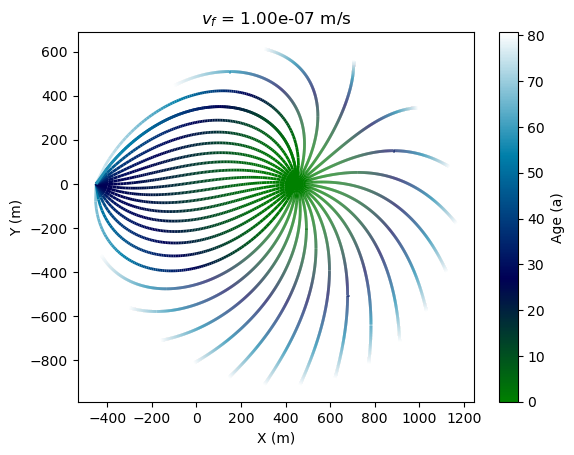

In [5]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from cgplot import plot_with_color_gradient, finalize_plot
from numba import jit, njit

# Calculate velocity field components
@jit(nopython=True)
def velocity_field(t, pos):
    """
    Returns the velocity field at a given position for the doublet system.
    Parameters:
        t (float): Time (not used, for ODE compatibility)
        pos (array): Position [x, y]
    Returns:
        list: [-U, -V] velocity components
    """
    x, y = pos
    A = (x + a)**2 + y**2
    B = (x - a)**2 + y**2
    U = v0*np.cos(alpha) + Q/(2*np.pi*M)*((x+a)/A - (x-a)/B)
    V = v0*np.sin(alpha) + Q/(2*np.pi*M)*(y/A - y/B)
    return [-U, -V]

# Define event to stop integration when the point is closer than 0.1 m to (-a, 0)
@jit(nopython=True)
def close_to_point(t, pos):
    """
    Event function to stop integration when the trajectory is close to the extraction well.
    Parameters:
        t (float): Time
        pos (array): Position [x, y]
    Returns:
        float: Distance to extraction well minus threshold
    """
    x, y = pos
    distance = np.sqrt((x + a)**2 + y**2)
    return distance - 0.1

close_to_point.terminal = True
close_to_point.direction = 0

# Numerical integration using 4th order Runge-Kutta method
def integration(x_start, y_start, t_span, dt, N=100):
    """
    Integrate the streamline from a starting point using the velocity field.
    Parameters:
        x_start (float): Starting x position
        y_start (float): Starting y position
        t_span (tuple): (start_time, end_time)
        dt (float): Time step
        N (int): Number of output points
    Returns:
        tuple: (t, y, solution) where t is time, y is trajectory, solution is ODE result
    """
    t_eval = np.arange(t_span[0], t_span[1], dt)
    initial_conditions = [x_start, y_start]
    solution = solve_ivp(
        velocity_field,
        t_span,
        initial_conditions,
        method='LSODA',
        t_eval=t_eval,
        rtol=1e-5,
        atol=1e-8,
        max_step=30*24*3600,
        events=close_to_point,
        dense_output=True,
        first_step=0.1
    )
    if solution.status == 1:
        if solution.t_events[0].size > 0:
            t = list()
            y = list()
            tmax = solution.t_events[0][0]
            for a in range(N+1):
                tn = a/N * tmax
                t.append(tn)
                y.append(solution.sol(tn))
            t = np.array(t).transpose()
            y = np.array(y).transpose()
        else:
            print("An error occurred?!?")
            t = solution.t
            y = solution.y
    else:
        t = solution.t
        y = solution.y
    return np.array(t), np.array(y), solution

# Starting point and parameters
beta = 0 #np.pi/2
delta = 1

x_start, y_start = a + delta*np.sin(beta), 0.0 + delta*np.cos(beta)
t_span = (0, tmax*a2s)  # Start and end time
dt = 0.05 * a2s

doplot = True

if doplot:
    plt.figure()
    plt.title(f"$v_f$ = {v0:.2e} m/s")

I = list()
betas = np.linspace(0, 2*np.pi, 36)

def calc_streamline(beta, doplot=doplot):
    """
    Calculate a streamline for a given angle beta.
    Parameters:
        beta (float): Angle for streamline start
        doplot (bool): Whether to plot the streamline
    Returns:
        float: Residence time (years)
    """
    x_start, y_start = a + delta*np.sin(beta), 0.0 + delta*np.cos(beta)
    t, trajectory, solution = integration(x_start, y_start, t_span, dt)
    if doplot:
        plot_with_color_gradient(trajectory[0][:], trajectory[1][:], t/a2s, zmin=0, zmax=tmax, cmap='ocean', linewidth=2)
    return t[-1]/a2s

for beta in betas:
    tau = calc_streamline(beta)
    I.append(tau)

if doplot:
    finalize_plot()

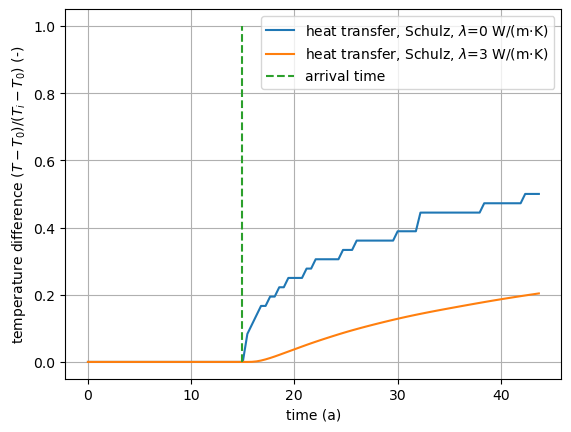

In [6]:
from scipy.special import erfc

time = np.linspace(0, tmax*G-1, 100) # The calculation is only valid for the period tmax*G-1. For a longer period, change parameter tmax.

for lambda_ in [1e-8, lambda_S]:
    H = np.sqrt(lambda_*rho_S*c_S) / (M * rho_F * c_F)
    T = np.zeros_like(time)
    for tau in I:
        U = np.heaviside(time-G*tau, 1)
        ind = U > 0
        abc = erfc(H*tau*np.sqrt(a2s)/np.sqrt(time[ind]-G*tau))
        T[ind] = T[ind] + U[ind]*abc
    plt.plot(time, T/len(I), label=f"heat transfer, Schulz, $\\lambda$={lambda_:.0f} W/(m$\\cdot$K)")

plt.plot([tb, tb], [0, 1], '--', label="arrival time")

plt.grid()
plt.xlabel("time (a)")
plt.ylabel("temperature difference $(T - T_0) / (T_i - T_0)$ (-)")
plt.legend()
plt.show()

The steps observed in solution can be explained by the fact that advective arrival times are summed over a finite number of streamlines. Increasing the number of streamlines would result in a smoother curve, but this would also increase the computation time.